In [2]:
# 1. Import Required Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import tensorflow as tf

In [3]:
# 2. Load Dataset (Titanic as example)
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
data = pd.read_csv(url)

In [4]:
# Explore Dataset
print("Shape of dataset:", data.shape)
print("\nData Types:\n", data.dtypes)
print("\nMissing Values:\n", data.isnull().sum())
print("\nFirst 5 Rows:\n", data.head())

Shape of dataset: (891, 12)

Data Types:
 PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Missing Values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

First 5 Rows:
    PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John 

In [5]:
# Select features (simulate numerical + categorical)
features = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked']
target = 'Survived'
X = data[features]
y = data[target]

In [6]:
# 3. Identify Numerical and Categorical Columns
num_features = ['Age', 'Fare']
cat_features = ['Pclass', 'Sex', 'Embarked']

In [7]:
# 4. Create Pipelines for Preprocessing
# Numerical: Median Imputation + Scaling
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical: Most Frequent Imputation + OneHotEncoding
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine Pipelines
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])


In [8]:
# 5. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nShape before preprocessing:")
print("X_train:", X_train.shape, "X_test:", X_test.shape)


Shape before preprocessing:
X_train: (712, 5) X_test: (179, 5)


In [9]:
# 6. Fit and Transform the Data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("\nShape after preprocessing:")
print("X_train_processed:", X_train_processed.shape, "X_test_processed:", X_test_processed.shape)


Shape after preprocessing:
X_train_processed: (712, 10) X_test_processed: (179, 10)


In [10]:
# 7. Convert to TensorFlow Tensors
X_train_tensor = tf.convert_to_tensor(X_train_processed.toarray() if hasattr(X_train_processed, 'toarray') else X_train_processed, dtype=tf.float32)
X_test_tensor = tf.convert_to_tensor(X_test_processed.toarray() if hasattr(X_test_processed, 'toarray') else X_test_processed, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train.values, dtype=tf.int32)
y_test_tensor = tf.convert_to_tensor(y_test.values, dtype=tf.int32)

print("\nTensor Shapes:")
print("X_train_tensor:", X_train_tensor.shape)
print("y_train_tensor:", y_train_tensor.shape)


Tensor Shapes:
X_train_tensor: (712, 10)
y_train_tensor: (712,)



Test Loss: 0.4287
Test Accuracy: 0.8045
Test Precision: 0.8000
Test Recall: 0.7027
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.88      0.84       105
           1       0.80      0.70      0.75        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



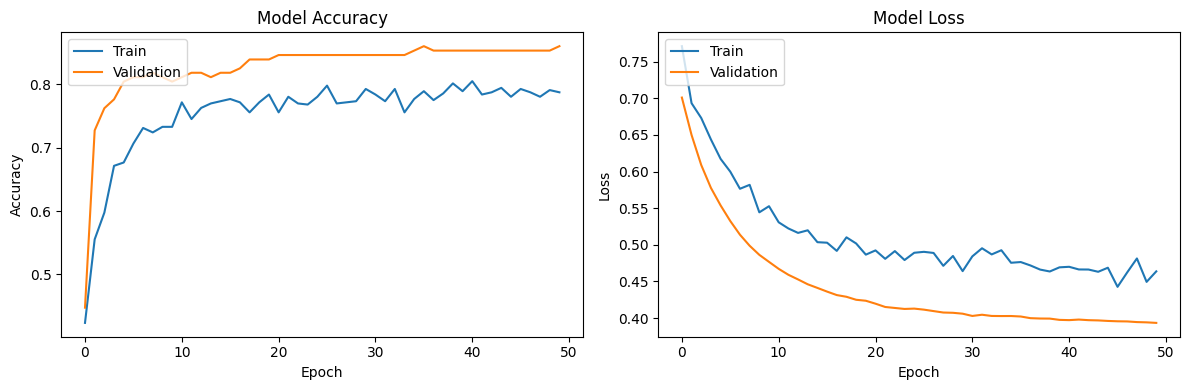

In [11]:
# 8. Model Training (Example with a simple TensorFlow model)
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_tensor.shape[1],)), # Input layer
    tf.keras.layers.Dense(32, activation='relu'), # Hidden layer
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid') # Output layer for binary classification
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Train the model
history = model.fit(X_train_tensor, y_train_tensor, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# 9. Evaluate the Model
loss, accuracy, precision, recall = model.evaluate(X_test_tensor, y_test_tensor, verbose=0)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")

# Generate predictions
y_pred_tensor = model.predict(X_test_tensor)
y_pred = (y_pred_tensor > 0.5).astype("int32").flatten()

# 10. Classification Report
from sklearn.metrics import classification_report
print("\nClassification Report:\n", classification_report(y_test_tensor.numpy(), y_pred))

# 11. Visual Outputs (Example: Plotting Training History)
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()